## indlæs, lav graf

In [2]:
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt

# 1. Læs data
df = pd.read_csv("data/overview.csv")
movies_df = pd.read_csv("data/movies.csv")

# 2. Rens cast-kolonne
df["cast_names"] = df["cast_names"].fillna("").astype(str)

# 3. Lav cast_list
df["cast_list"] = df["cast_names"].apply(
    lambda s: [c.strip() for c in s.split("|") if c.strip() != ""]
)

# 4. Join overview med movies
merged_df = df.merge(movies_df[["movieId", "genres"]], on="movieId", how="left")

# 5. Split genres til liste
merged_df["genres"] = merged_df["genres"].fillna("")
merged_df["genre_list"] = merged_df["genres"].apply(
    lambda s: [g.strip() for g in s.split("|") if g.strip() != ""]
)
# tæl forekomster af hver genre


# 6. Filtrér på en bestemt genre (præcist match)
target_genre = "Action"   # ← Skift her


genre_df = merged_df[merged_df["genre_list"].apply(lambda lst: target_genre in lst) ].copy()

# tag links csv filen og sørg for den kun indeholder film fra genre_df
#links_df = pd.read_csv("data/links.csv")
#links_df = links_df[ links_df["movieId"].isin( genre_df["movieId"] ) ]
#print(links_df.head())
# giv mig links_df som csv eksporter
#links_df.to_csv("data/links_action.csv", index=False)
# 7. Tjek resultat
#print(genre_df.head())
# antal film før filtrering
print("Antal film i alt:", len(merged_df))
print("Antal film i genren:", len(genre_df))
# vis genre kolonenn
#print(merged_df[ "genre_list"].head())

Antal film i alt: 86411
Antal film i genren: 9553


In [3]:
all_genres = list(itertools.chain.from_iterable(merged_df["genre_list"]))
genre_counts = pd.Series(all_genres).value_counts()
print("Genre counts:")
print(genre_counts)


Genre counts:
Drama                 33647
Comedy                22798
Thriller              11668
Romance               10159
Action                 9553
Documentary            9232
Horror                 8565
(no genres listed)     7059
Crime                  6912
Adventure              5345
Sci-Fi                 4844
Animation              4571
Children               4365
Mystery                3967
Fantasy                3819
War                    2297
Western                1690
Musical                1054
Film-Noir               353
IMAX                    195
Name: count, dtype: int64


In [4]:
# 4. Opret graf
G = nx.Graph()

for cast in genre_df["cast_list"]:
    # Tilføj noder (skuespillere)
    for actor in cast:
        if actor not in G:
            G.add_node(actor)
    
    # Tilføj kanter for alle par af skuespillere i samme film
    for a, b in itertools.combinations(cast, 2):
        if G.has_edge(a, b):
            # øg vægten hvis kanten allerede findes
            G[a][b]["weight"] += 1
        else:
            G.add_edge(a, b, weight=1)

# 5. Evt. filtrer netværket (f.eks. kun skuespillere med mindst X forbindelser)
# Her laver vi fx et subgraf med skuespillere, der har mindst 3 naboer
min_degree = 0
nodes_to_keep = [n for n, d in G.degree() if d >= min_degree]
H = G.subgraph(nodes_to_keep).copy()

# print nogle informationer om grafen
print("Original graf: {} noder, {} kanter".format(G.number_of_nodes(), G.number_of_edges()))
print("Subgraf med mindst {} forbindelser: {} noder, {} kanter".format(min_degree, H.number_of_nodes(), H.number_of_edges()))

Original graf: 45153 noder, 378226 kanter
Subgraf med mindst 0 forbindelser: 45153 noder, 378226 kanter


## Graf undersøgelse

- Degree Distribtuion
- Hvem har lavest og højest degree distribution
- Max/min degree

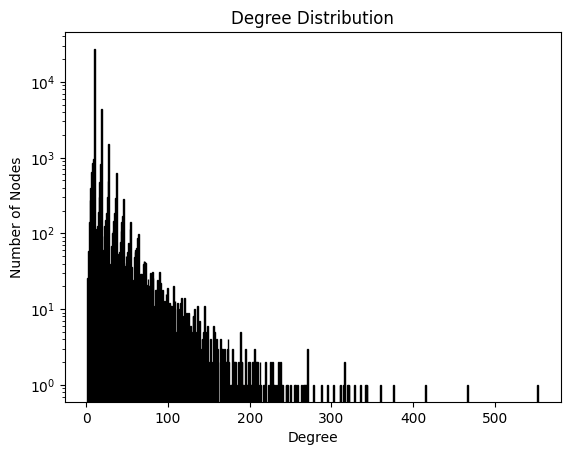

In [5]:
# Degree distribution plot
degrees = [d for n, d in H.degree()]
plt.hist(degrees, bins=range(1, max(degrees)+1), edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.yscale('log')  # Log-skala for bedre visualisering
plt.show()

In [6]:
# Højst og lavest degree
degree_sequence = sorted(H.degree(), key=lambda x: x[1], reverse=True)
print("\nTop 5 skuespillere efter degree:")
for actor, degree in degree_sequence[:5]:
    print(f"{actor}: {degree}")
print("\nBottom 5 skuespillere efter degree:")
for actor, degree in degree_sequence[-5:]:
    print(f"{actor}: {degree}")


Top 5 skuespillere efter degree:
Jackie Chan: 553
Bruce Willis: 466
Danny Trejo: 415
Samuel L. Jackson: 375
Eric Roberts: 360

Bottom 5 skuespillere efter degree:
Ingó Ingólfsson: 0
Rob Newman: 0
Don Hertzfeldt: 0
Kibwe Tavares: 0
Lilian Constantini: 0


In [7]:
# Max og min degree
max_degree_actor, max_degree = degree_sequence[0]
min_degree_actor, min_degree = degree_sequence[-1]
print("\nSkuespiller med højst degree: {} ({})".format(max_degree_actor, max_degree))
print("Skuespiller med lavest degree: {} ({})".format(min_degree_actor, min_degree))


Skuespiller med højst degree: Jackie Chan (553)
Skuespiller med lavest degree: Lilian Constantini (0)


## Community

- Modularity
- Structural Communities (Louvain algorithm) to find optimal structural communities
- Purity metrics - Community purity


In [8]:
# Modularity (fællesskabsdetektion)
from networkx.algorithms import community
communities = community.greedy_modularity_communities(H)
print("\nAntal fællesskaber fundet:", len(communities))
for i, comm in enumerate(communities):
    print(f"Fællesskab {i+1}: {len(comm)} noder")


Antal fællesskaber fundet: 713
Fællesskab 1: 13291 noder
Fællesskab 2: 8613 noder
Fællesskab 3: 5586 noder
Fællesskab 4: 3651 noder
Fællesskab 5: 3126 noder
Fællesskab 6: 1061 noder
Fællesskab 7: 523 noder
Fællesskab 8: 248 noder
Fællesskab 9: 242 noder
Fællesskab 10: 230 noder
Fællesskab 11: 204 noder
Fællesskab 12: 170 noder
Fællesskab 13: 168 noder
Fællesskab 14: 125 noder
Fællesskab 15: 121 noder
Fællesskab 16: 100 noder
Fællesskab 17: 97 noder
Fællesskab 18: 84 noder
Fællesskab 19: 78 noder
Fællesskab 20: 61 noder
Fællesskab 21: 60 noder
Fællesskab 22: 60 noder
Fællesskab 23: 59 noder
Fællesskab 24: 53 noder
Fællesskab 25: 51 noder
Fællesskab 26: 49 noder
Fællesskab 27: 48 noder
Fællesskab 28: 48 noder
Fællesskab 29: 45 noder
Fællesskab 30: 44 noder
Fællesskab 31: 44 noder
Fællesskab 32: 43 noder
Fællesskab 33: 42 noder
Fællesskab 34: 39 noder
Fællesskab 35: 39 noder
Fællesskab 36: 39 noder
Fællesskab 37: 38 noder
Fællesskab 38: 37 noder
Fællesskab 39: 35 noder
Fællesskab 40: 34 

In [9]:
# Louvian metode
from community import community_louvain
partition = community_louvain.best_partition(H)
num_communities = len(set(partition.values()))
print("\nLouvian metode fandt {} fællesskaber".format(num_communities))


Louvian metode fandt 462 fællesskaber


## Connectivity

- Giant Connected Component
- Weakly Connected Component

In [10]:
# Giant connected component
largest_cc = max(nx.connected_components(H), key=len)
GCC = H.subgraph(largest_cc).copy()
print("\nGiant Connected Component: {} noder, {} kanter".format(GCC.number_of_nodes(), GCC.number_of_edges()))


Giant Connected Component: 42658 noder, 368323 kanter


In [11]:
# Weakly Connected Components
wccs = list(nx.connected_components(H))
print("\nAntal svagt forbundne komponenter:", len(wccs))


Antal svagt forbundne komponenter: 296


## Network Modellering

- Small World
- Scale Free
- Power Law Exponent
- Bipartite Network (anti block diagonals and perform projections)

## Centrality

- Top 5 nodes for Degree Centrality
- Top 5 nodes for Betweenness Centrality
- Top 5 nodes for Eigenvector Centrality

In [12]:
# Degree centrality
degree_centrality = nx.degree_centrality(G)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nTop 5 skuespillere efter degree centrality:")
for actor, centrality in sorted_degree[:5]:
    print(f"{actor}: {centrality:.4f}")


Top 5 skuespillere efter degree centrality:
Jackie Chan: 0.0122
Bruce Willis: 0.0103
Danny Trejo: 0.0092
Samuel L. Jackson: 0.0083
Eric Roberts: 0.0080


In [13]:
# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nTop 5 skuespillere efter betweenness centrality:")
for actor, centrality in sorted_betweenness[:5]:
    print(f"{actor}: {centrality:.4f}")


Top 5 skuespillere efter betweenness centrality:
Jackie Chan: 0.0240
Sylvester Stallone: 0.0155
Hiroyuki Sanada: 0.0142
Danny Trejo: 0.0126
Bruce Willis: 0.0122


In [14]:
# Eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
sorted_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nTop 5 skuespillere efter eigenvector centrality:")
for actor, centrality in sorted_eigenvector[:5]:
    print(f"{actor}: {centrality:.4f}")


Top 5 skuespillere efter eigenvector centrality:
Jackie Chan: 0.1582
Sammo Hung Kam-Bo: 0.1468
Donnie Yen: 0.1309
Ku Feng: 0.1149
Lo Lieh: 0.1146


## Correlation

- Spearman
- Pearson


In [15]:
# Spearman korrelation mellem centralitetsmålene
from scipy.stats import spearmanr
degree_values = [v for k, v in sorted_degree]
betweenness_values = [v for k, v in sorted_betweenness]
eigenvector_values = [v for k, v in sorted_eigenvector]

## Assortativity

- Degree Assortativity
- Attribute Assortativity

In [16]:
# Degree assortativity
assortativity = nx.degree_assortativity_coefficient(G)
print("\nDegree assortativity koefficient:", assortativity)


Degree assortativity koefficient: 0.09870905162681685


## Visualization

- Layouts (spring_layout vs kamada_kawai_layout)
- ForceAtlas2 for aestethic visualizations
- Node size depending on degree
- Heatmaps, plot of in and out degrees
- Backbone - Displarity Filter & High-Salience Skeleteon (HSS) 


Backbone graf efter Disparity Filter: 45153 noder, 12097 kanter


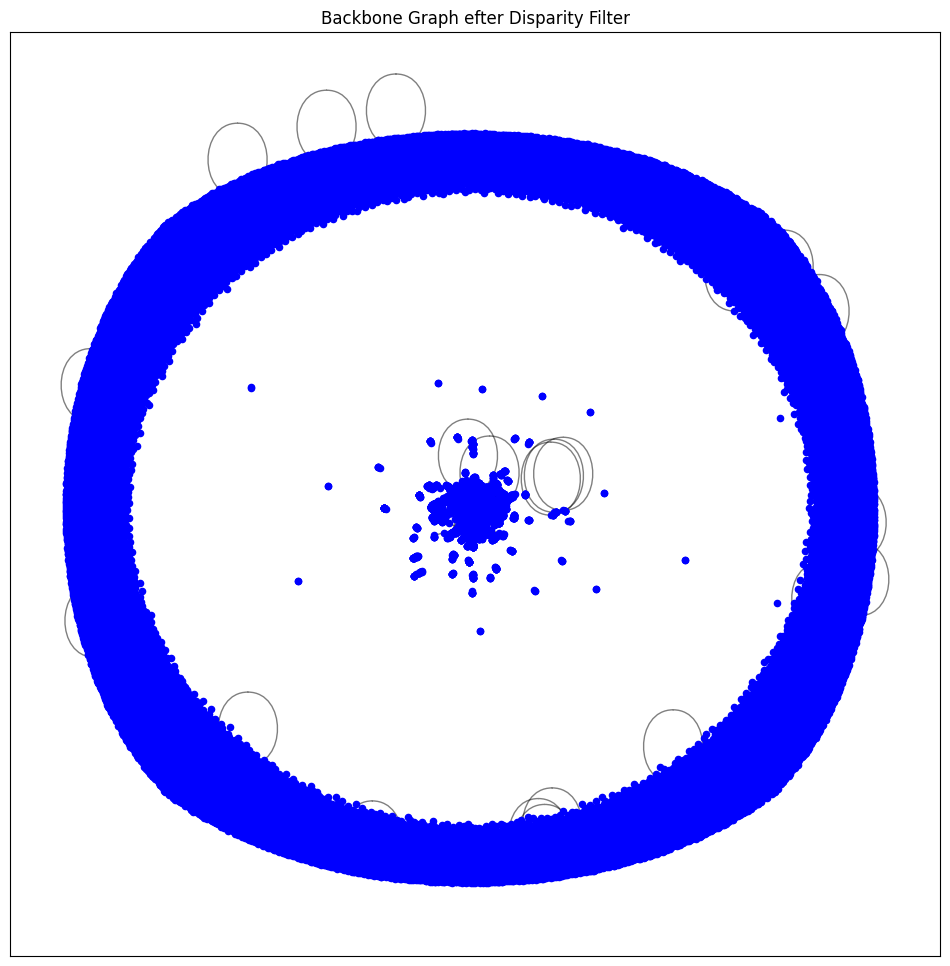

In [17]:
import networkx as nx
import math

def disparity_filter(G, alpha=0.05):
    """
    Extract backbone using the Disparity Filter method.
    G: weighted NetworkX graph
    alpha: significance threshold (default 0.05)
    Returns: backbone graph (NetworkX)
    """
    backbone = nx.Graph()
    backbone.add_nodes_from(G.nodes(data=True))

    for node in G.nodes():
        k = len(list(G.neighbors(node)))     # degree
        if k <= 1:
            # keep all edges for nodes with degree 1
            for nbr, data in G[node].items():
                backbone.add_edge(node, nbr, **data)
            continue

        # sum of incident weights
        w_sum = sum(data["weight"] for _, data in G[node].items())

        for nbr, data in G[node].items():
            w = data["weight"]
            p_ij = w / w_sum

            # Disparity Filter significance test
            alpha_ij = 1 - (1 - p_ij) ** (k - 1)

            if alpha_ij < alpha:
                # keep significant edge
                backbone.add_edge(node, nbr, **data)

    return backbone

# Anvend disparity filter på grafen H
backbone_H = disparity_filter(H, alpha=0.5)
print("\nBackbone graf efter Disparity Filter: {} noder, {} kanter".format(backbone_H.number_of_nodes(), backbone_H.number_of_edges()))

# plot
pos = nx.spring_layout(backbone_H, seed=42)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(backbone_H, pos, node_size=20, node_color='blue')
nx.draw_networkx_edges(backbone_H, pos, alpha=0.5)
plt.title("Backbone Graph efter Disparity Filter")
plt.show()
